## Training a Semantic Segmentation model on the MaSTr1325 Dataset

### https://box.vicos.si/borja/viamaro/index.html#references

### Import relevent packages

In [145]:
import numpy as np
import random
import sys
import skimage.io
from PIL import Image
import cv2
#import segmentation_models as sm
import matplotlib.image as mpimg
import glob
from PIL import Image
import scipy.io as sio
import numpy
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow import keras

### Define helper functions from CAB420

In [146]:
def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

def random_crop(img_x, img_y, random_crop_size):

    height, width = img_x.shape[0], img_x.shape[1]
    dy, dx = random_crop_size
    x = numpy.random.randint(0, width - dx + 1)
    y = numpy.random.randint(0, height - dy + 1)
    return img_x[y:(y+dy), x:(x+dx), :], img_y[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        batch_crops_y = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crops_x, mask_to_categorical(batch_crops_y, 5))
        
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def create_callbacks():
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)
    return [scheduler_callback, early_stopping]

def create_optimiser():
    return tf.keras.optimizers.Adam()
steps_per_epoch = 100
epochs = 50

def visualise(model, test_data, test_gt):
    pred = model.predict(test_data)
    fig = plt.figure(figsize=[20, 25])
    for i,img in enumerate(test_data):
        if (i < 32):
            ax = fig.add_subplot(8, 8, i*2 + 1)
            ax.imshow(img)
            ax = fig.add_subplot(8, 8, i*2 + 2)
            ax.imshow(categorical_to_mask(pred[i,:,:,:]))  

### Import all the data

In [147]:
def load_mask_files(path, target_size, scale_factor):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    print(filenames)
    #filenames = (filenames.split("m")[0] + ".png")
    for filename in filenames:
        im = Image.open(filename)
        w, h = im.size
        im = im.resize((target_size, target_size))
        im=numpy.asarray(im) / scale_factor
        image_list.append(im)
    return numpy.asarray(image_list)

In [148]:
def load_image_files(path, target_size):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    #filenames.sort(key=lambda f: int(filter(str.isdigit, f)))
    #print(filenames)
    for filename in filenames:
        image = cv2.imread(filename)
        image = cv2.resize(image, (target_size, target_size))

        #hsvImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image_list.append(image)
    return numpy.asarray(image_list)

### Define custom train and test data split

In [149]:
def train_test_split_custom(images, masks):

    train_images = []
    test_images = []
    train_masks = []
    test_masks = []

    iteration_check = 0

    for i in range(len(images)):

        if (iteration_check == 5):
            test_images.append(images[i])
            test_masks.append(masks[i])
            iteration_check = 0
        else:
            train_images.append(images[i])
            train_masks.append(masks[i])
            iteration_check += 1

    train_masks = np.array(train_masks)
    test_masks = np.array(test_masks)
    train_images = np.array(train_images)
    test_images = np.array(test_images)
    
    return train_images, test_images, train_masks, test_masks

# Test colour change

In [6]:
images = load_image_files('../Data/MaSTr1325_images/*', 480)
masks = load_mask_files('../Data/MaSTr1325_masks/*', 480, 1.0)

# images = images[0:1000]
# masks = masks[0:1000]

['../Data/MaSTr1325_masks\\0001.png', '../Data/MaSTr1325_masks\\0002.png', '../Data/MaSTr1325_masks\\0003.png', '../Data/MaSTr1325_masks\\0004.png', '../Data/MaSTr1325_masks\\0005.png', '../Data/MaSTr1325_masks\\0006.png', '../Data/MaSTr1325_masks\\0007.png', '../Data/MaSTr1325_masks\\0008.png', '../Data/MaSTr1325_masks\\0009.png', '../Data/MaSTr1325_masks\\0010.png', '../Data/MaSTr1325_masks\\0011.png', '../Data/MaSTr1325_masks\\0012.png', '../Data/MaSTr1325_masks\\0013.png', '../Data/MaSTr1325_masks\\0014.png', '../Data/MaSTr1325_masks\\0015.png', '../Data/MaSTr1325_masks\\0016.png', '../Data/MaSTr1325_masks\\0017.png', '../Data/MaSTr1325_masks\\0018.png', '../Data/MaSTr1325_masks\\0019.png', '../Data/MaSTr1325_masks\\0020.png', '../Data/MaSTr1325_masks\\0021.png', '../Data/MaSTr1325_masks\\0022.png', '../Data/MaSTr1325_masks\\0023.png', '../Data/MaSTr1325_masks\\0024.png', '../Data/MaSTr1325_masks\\0025.png', '../Data/MaSTr1325_masks\\0026.png', '../Data/MaSTr1325_masks\\0027.png', 

In [7]:
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))
masks = tf.keras.utils.to_categorical(masks, num_classes=None)
masks = masks[:,:,:,:4]

In [8]:
for i in range(np.shape(images)[0]):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

NameError: name 'images' is not defined

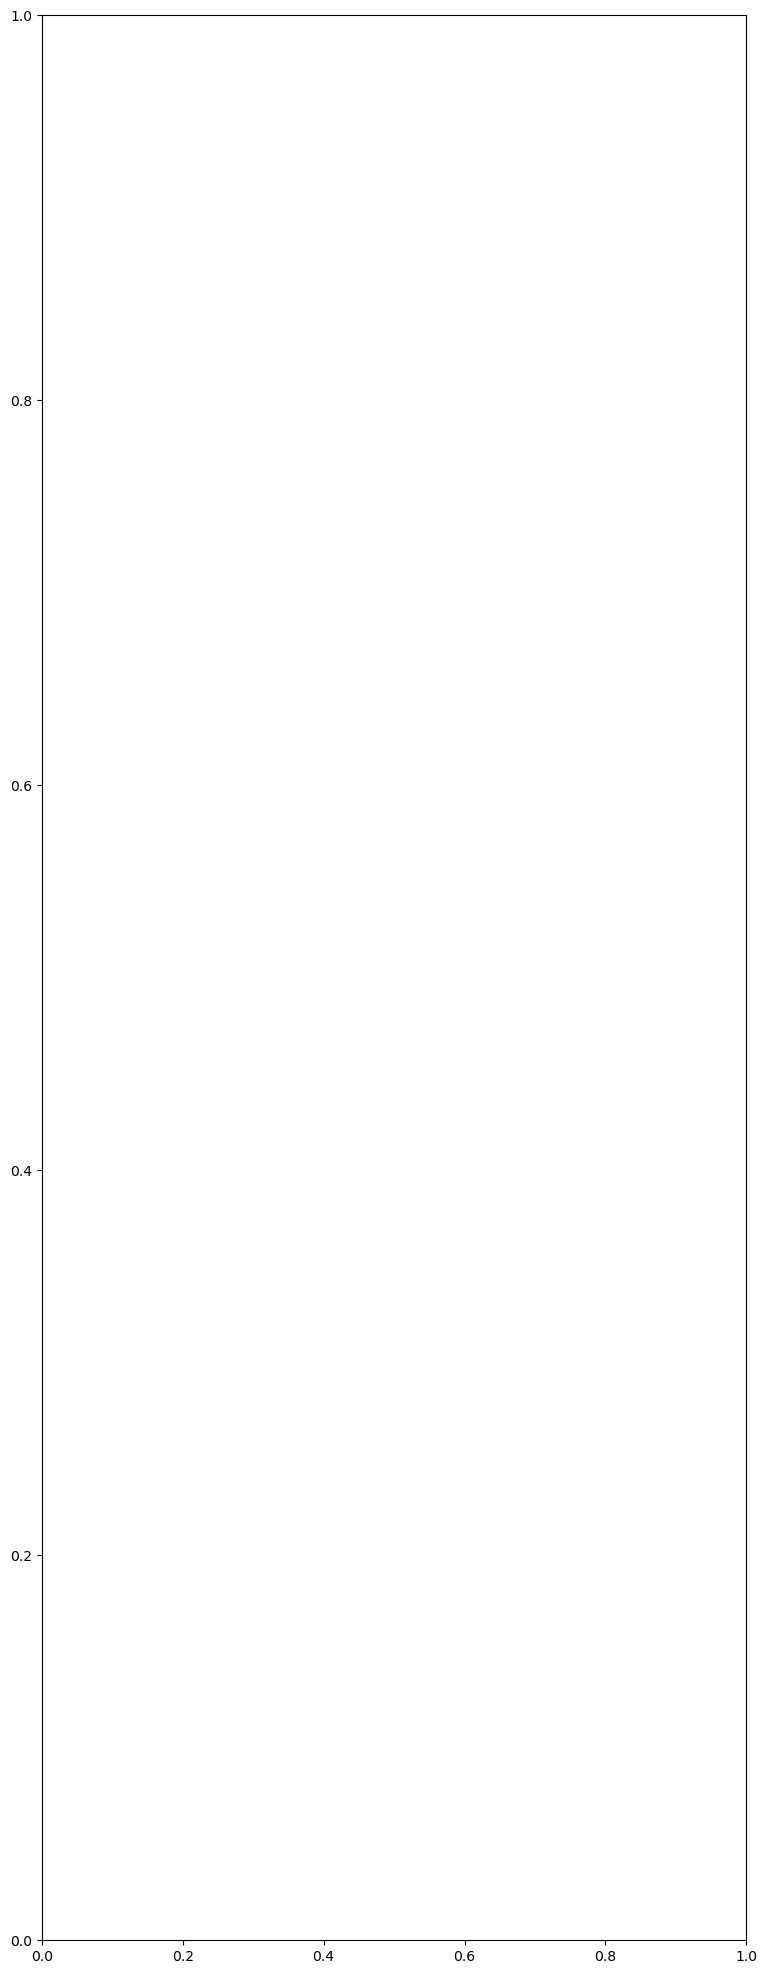

In [6]:
image_number = 1029

fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(images[image_number])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(masks[image_number, :, :, :]))

In [9]:
# Create sky colour pallet
palette = np.array([[230,228,242],[182,202,242],[206, 218, 242]])#[194, 210, 242])#,[173, 188, 217],[206, 218, 242], [177, 191, 220], [231, 221, 229]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedSky = np.load('skyColourPallete3.npz')['color_cube']
except:
    precalculatedSky = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedSky[i,j,k] = palette[index]
    np.savez_compressed('skyColourPallete3', color_cube = precalculatedSky)

In [10]:
# Create water colour pallet
palette = np.array([[73, 128, 140],[66, 112, 140],[85, 132, 159]])#,[56, 105, 122], [90, 121, 152]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedWater = np.load('waterColourPallete3.npz')['color_cube']
except:
    precalculatedWater = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedWater[i,j,k] = palette[index]
    np.savez_compressed('waterColourPallete3', color_cube = precalculatedWater)

In [11]:
def get_view(image, mask):
    # Iterate to get to each pixel
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (np.argmax(mask[i][j]) == 2):

                # get the individual pixel RGB values
                indices = image[i,j]

                # pass image colors and retrieve corresponding palette color
                image[i,j] = precalculatedSky[indices[0],indices[1],indices[2]]
            elif (np.argmax(mask[i][j]) == 1):
                # get the individual pixel RGB values
                indices = image[i,j]

                # pass image colors and retrieve corresponding palette color
                image[i,j] = precalculatedWater[indices[0],indices[1],indices[2]]
    return image

# start = time.time()
# result = get_view(image)
# print('Image processing: ',time.time()-start)
# Image.fromarray(result).show()

### Apply image colour change to whole dataset

In [12]:
for i in range(np.shape(images)[0]):
    images[i] = get_view(images[i], masks[i])

### environment = 0, water = 1, sky = 2, ignore = 3


### Load Data and run through split

In [13]:
i = 0
for image in images:
    j = (f"{(i+1):04d}")
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./images7480p/" + j+".jpg", image)
    i += 1

In [6]:
images = load_image_files('images7480p/*', 480)
masks = load_mask_files('../Data/MaSTr1325_masks/*', 480, 1)
#masks = masks[0:1000]
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))
masks = tf.keras.utils.to_categorical(masks, num_classes=None)
masks = masks[:,:,:,:4]

['../Data/MaSTr1325_masks\\0001.png', '../Data/MaSTr1325_masks\\0002.png', '../Data/MaSTr1325_masks\\0003.png', '../Data/MaSTr1325_masks\\0004.png', '../Data/MaSTr1325_masks\\0005.png', '../Data/MaSTr1325_masks\\0006.png', '../Data/MaSTr1325_masks\\0007.png', '../Data/MaSTr1325_masks\\0008.png', '../Data/MaSTr1325_masks\\0009.png', '../Data/MaSTr1325_masks\\0010.png', '../Data/MaSTr1325_masks\\0011.png', '../Data/MaSTr1325_masks\\0012.png', '../Data/MaSTr1325_masks\\0013.png', '../Data/MaSTr1325_masks\\0014.png', '../Data/MaSTr1325_masks\\0015.png', '../Data/MaSTr1325_masks\\0016.png', '../Data/MaSTr1325_masks\\0017.png', '../Data/MaSTr1325_masks\\0018.png', '../Data/MaSTr1325_masks\\0019.png', '../Data/MaSTr1325_masks\\0020.png', '../Data/MaSTr1325_masks\\0021.png', '../Data/MaSTr1325_masks\\0022.png', '../Data/MaSTr1325_masks\\0023.png', '../Data/MaSTr1325_masks\\0024.png', '../Data/MaSTr1325_masks\\0025.png', '../Data/MaSTr1325_masks\\0026.png', '../Data/MaSTr1325_masks\\0027.png', 

In [77]:
print(np.shape(masks))

(1030, 240, 240, 4)


In [7]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
def zoom(img, mask, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    mask = mask[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    mask = fill(mask, h, w)
    return img, mask

In [8]:
def horizontal_shift(img, mask, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
        mask = mask[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
        mask = mask[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    mask = fill(mask, h, w)
    return img, mask

In [9]:
def data_aug(images, masks):

    newTrainingImages = []
    newTrainingMasks = []

    for i in range(len(images)):

        #shiftImage, shiftMask = horizontal_shift(images[i], masks[i], 0.7)

        newTrainingImages.append(images[i])
        newTrainingMasks.append(masks[i])

        if (i % 5 == 0 and i % 10 != 0):
            flipped = cv2.flip(images[i], 1)
            flipped_mask = cv2.flip(masks[i], 1)
            newTrainingImages.append(flipped)
            newTrainingMasks.append(flipped_mask)
        elif (i % 10 == 0):
            zoomedImage, zoomedMask = zoom(images[i], masks[i], 0.5)
            newTrainingImages.append(zoomedImage)
            newTrainingMasks.append(zoomedMask)
            
        # newTrainingImages.append(shiftImage)
        # newTrainingMasks.append(shiftMask)

    newTrainingImages = numpy.array(newTrainingImages)
    newTrainingMasks = numpy.array(newTrainingMasks)
        
    return newTrainingImages, newTrainingMasks

In [13]:
images_augmented, masks_augmented = data_aug(images, masks)

In [24]:
print(np.shape(masks_augmented))
print(np.shape(images_augmented))

(1236, 360, 360, 4)
(1236, 360, 360, 3)


In [9]:
train_images, test_images, train_masks, test_masks = train_test_split_custom(images, masks)

In [14]:
train_images, test_images, train_masks, test_masks = train_test_split_custom(images_augmented, masks_augmented)

In [10]:
del images
del masks

In [8]:
for i in range(len(images)):    
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [11]:
print(np.shape(train_images))
print(np.shape(train_masks))
print(np.shape(test_images))
print(np.shape(test_masks))

(859, 480, 480, 3)
(859, 480, 480, 4)
(171, 480, 480, 3)
(171, 480, 480, 4)


In [59]:
image = images[0]

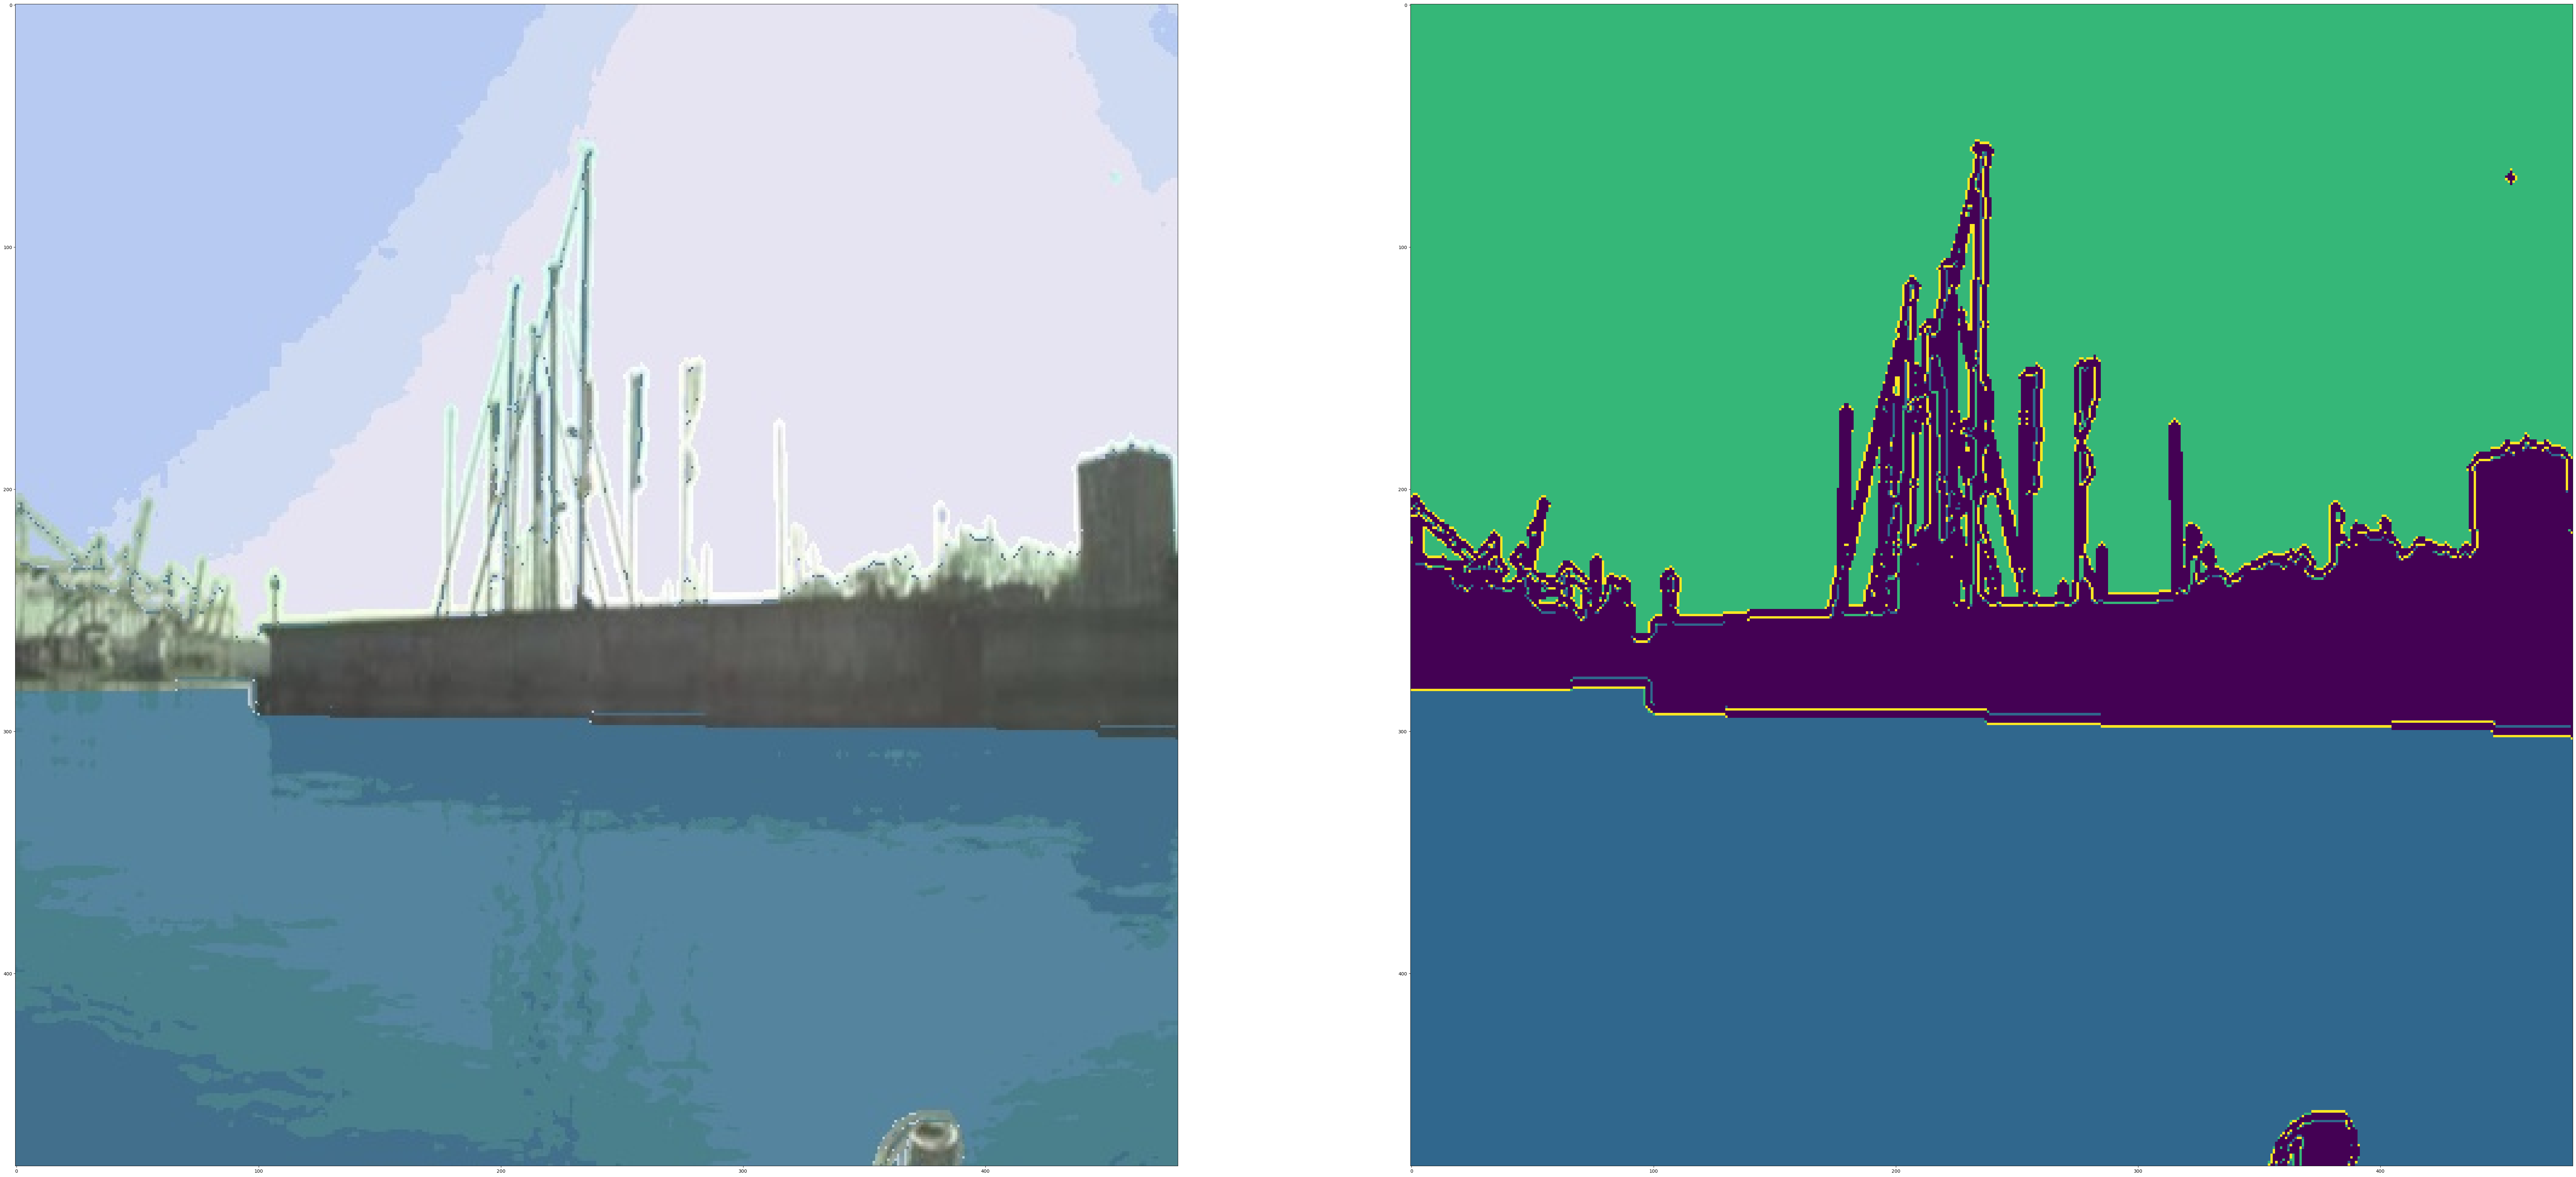

In [12]:
image_number = 0

fig = plt.figure(figsize=[100, 100])
ax = fig.add_subplot(1, 2, 1)
test = (train_images[image_number])
ax.imshow(test)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(train_masks[image_number]))


In [141]:
print(np.shape(train_images))
print(np.shape(test_images))
print(np.shape(train_masks))
print(np.shape(test_masks))

(3434, 240, 240, 3)
(686, 240, 240, 3)
(3434, 240, 240, 4)
(686, 240, 240, 4)


#### Create U-NET

In [13]:
input_img = Input(shape=(480, 480, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
decoded = Conv2D(4, (1, 1), activation='softmax', padding='same')(conv7)

unet = Model(input_img, decoded)
print(unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 480, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 480, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

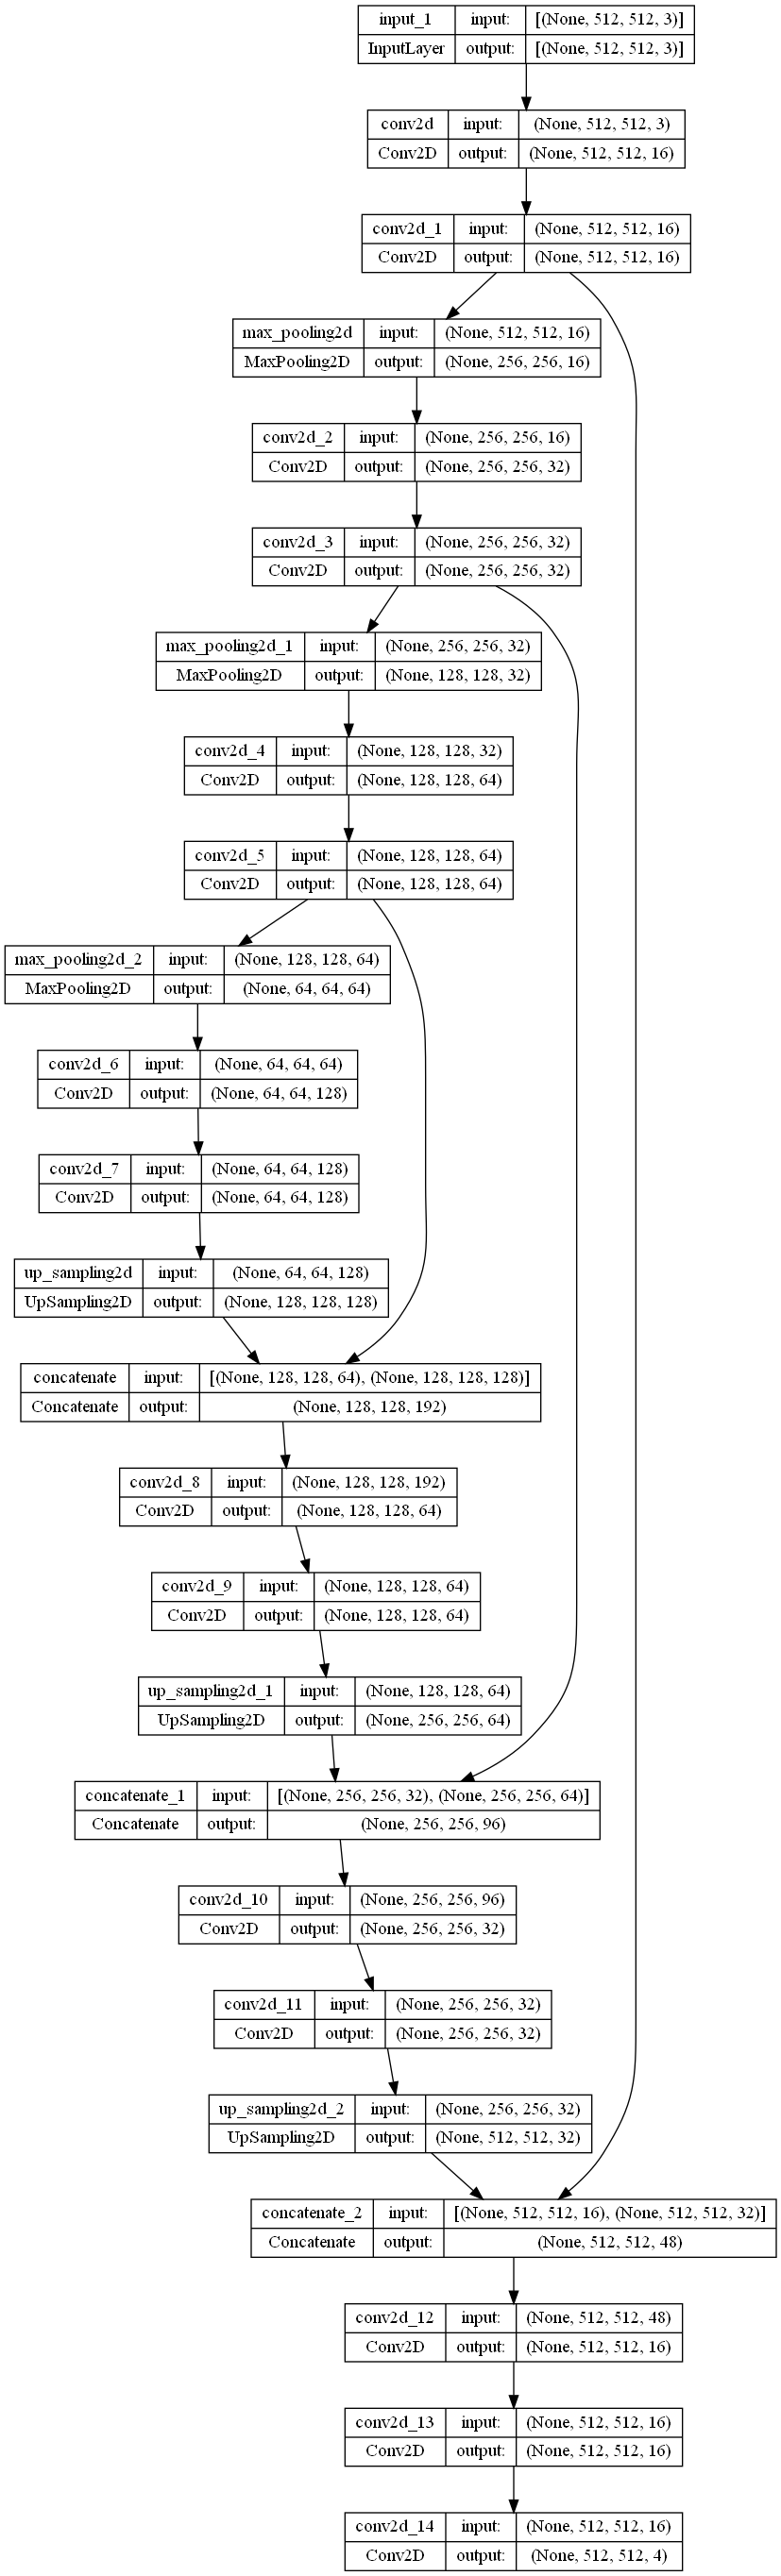

In [10]:
plot_model(unet, show_shapes=True)

In [36]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [33]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.666)


### Train U-Net on training data

In [157]:
del unet

In [43]:
#unet.compile(optimizer=create_optimiser(), loss=focal_loss)
unet.fit(train_images, train_masks, batch_size= 4, epochs = 100, validation_data=(test_images, test_masks), validation_steps = 10, callbacks=create_callbacks())

Epoch 1/100
215/215 [==============================] - 21s 96ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 2/100
215/215 [==============================] - 20s 94ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 3/100
215/215 [==============================] - 20s 95ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 4/100
215/215 [==============================] - 21s 96ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 5/100
215/215 [==============================] - 21s 96ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 6/100
215/215 [==============================] - 21s 97ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 7/100
215/215 [==============================] - 21s 97ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 8/100
215/215 [==============================] - 21s 97ms/step - loss: 0.0018 - val_loss: 0.0023 - lr: 2.7536e-08
Epoch 9/100
215/215 [===================

In [151]:
exampleImage = cv2.imread('../Results/semantic_input.jpg')
exampleImage = cv2.resize(exampleImage, (480, 480))

In [152]:
exampleImage = cv2.cvtColor(exampleImage, cv2.COLOR_BGR2RGB)
semantic_img_array = np.array(exampleImage)

# Expand dimensions to match the 4D Tensor shape.
semantic_img_array = np.expand_dims(semantic_img_array, axis=0)

In [44]:
output = unet.predict(semantic_img_array)

1/1 [==============================] - 0s 23ms/step


In [47]:
semantic_output2 = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [45]:
fig = plt.figure(figsize=[200, 250])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(exampleImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(output[0, :, :, :]))

In [46]:
unet.save('saved_model/semantic_segmentation_model_15_10_480p_loss_001_lower_lr')

INFO:tensorflow:Assets written to: saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr\assets


INFO:tensorflow:Assets written to: saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr\assets


In [150]:
semantic_segmentation_model = tf.keras.models.load_model('saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr', compile=False)

In [153]:
predict = semantic_segmentation_model.predict(semantic_img_array)
#semantic_output = cv2.cvtColor(predict, cv2.COLOR_BGR2RGB)

1/1 [==============================] - 2s 2s/step


In [154]:
fig = plt.figure(figsize=[200, 250])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(exampleImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(predict[0, :, :, :]))

In [155]:
#print(predict)
print(categorical_to_mask(predict[0, :, :, :])[240,:])

tf.Tensor(
[0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.01176471 0.01176471 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.01176471 0.01176471 0.00784314
 0.01176471 0.01176471 0.00392157 0.00392157 0.0039

In [122]:
print(maskIntoCategoriesArray)

[[0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 [0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 [0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]


In [124]:
import math

In [132]:
maskIntoCategoriesArray = np.round(maskIntoCategoriesArray, 4)

In [135]:
print(maskIntoCategoriesArray)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [156]:
maskIntoCategories = categorical_to_mask(predict[0, :, :, :])
maskIntoCategoriesArray = np.round(maskIntoCategoriesArray, 4)
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0)] = 0
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.004)] = 1
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.008)] = 2
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.012)] = 3

#### environment = 0, water = 1, sky = 2, ignore = 3


In [158]:
print(maskIntoCategoriesArray)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [144]:
cv2.imshow("test", maskIntoCategoriesArray)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1267: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [143]:
fig = plt.figure(figsize=[200, 250])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(exampleImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(maskIntoCategoriesArray)

In [ ]:
print(maskIntoCategories)

In [58]:
mask2 =  numpy.reshape(predict, (numpy.shape(predict) + (1, )))
mask2 = tf.keras.utils.to_categorical(mask2, num_classes=None)
mask2 = mask2[:,:,:4]
#mask = mask[:,:,:,:4]

In [49]:
print(np.shape(mask))

(1, 480, 480, 4, 1)


In [60]:
print(mask2)

[[[[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]


  ...


  [[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    [1.]]]]]


In [106]:
masks = load_mask_files('../Data/MaSTr1325_masks/*', 480, 1)
mask = masks[0]
# mask = numpy.reshape(mask, (numpy.shape(mask) + (1, )))
# mask = tf.keras.utils.to_categorical(mask, num_classes=None)
# mask = mask[:,:,:4]

['../Data/MaSTr1325_masks\\0001.png', '../Data/MaSTr1325_masks\\0002.png', '../Data/MaSTr1325_masks\\0003.png', '../Data/MaSTr1325_masks\\0004.png', '../Data/MaSTr1325_masks\\0005.png', '../Data/MaSTr1325_masks\\0006.png', '../Data/MaSTr1325_masks\\0007.png', '../Data/MaSTr1325_masks\\0008.png', '../Data/MaSTr1325_masks\\0009.png', '../Data/MaSTr1325_masks\\0010.png', '../Data/MaSTr1325_masks\\0011.png', '../Data/MaSTr1325_masks\\0012.png', '../Data/MaSTr1325_masks\\0013.png', '../Data/MaSTr1325_masks\\0014.png', '../Data/MaSTr1325_masks\\0015.png', '../Data/MaSTr1325_masks\\0016.png', '../Data/MaSTr1325_masks\\0017.png', '../Data/MaSTr1325_masks\\0018.png', '../Data/MaSTr1325_masks\\0019.png', '../Data/MaSTr1325_masks\\0020.png', '../Data/MaSTr1325_masks\\0021.png', '../Data/MaSTr1325_masks\\0022.png', '../Data/MaSTr1325_masks\\0023.png', '../Data/MaSTr1325_masks\\0024.png', '../Data/MaSTr1325_masks\\0025.png', '../Data/MaSTr1325_masks\\0026.png', '../Data/MaSTr1325_masks\\0027.png', 

In [101]:
test = categorical_to_mask(predict[0, :, :, :])


In [91]:
print(np.shape(test))

(480, 480, 4)


In [70]:
classes = {
  0: "Environment",
  1: "Water",
  2: "Sky",
  3: "Ignore"
}

In [73]:
output = np.array(predict[0])